In [2]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
from tqdm import tqdm
from preprocessing import PastUserState,extract_data_mooc,PreviousItemInteraction, extractFeatures,extractItemUserId,extractPastItem,extractNextUserState,UserNextInteraction, delta, t_batch_update,train_test_split,train_test_stratified_split
from model import RODIE
from sklearn.manifold import TSNE
from train import dynamic_embedding,train_rodie
from  torch import nn
from torch.nn import RNNCell
from torch.nn.functional import one_hot
import math
from torch.nn import functional as F
from torch.nn import MSELoss, HuberLoss,L1Loss,CrossEntropyLoss
from tqdm import tqdm


torch.backends.cudnn.benchmark = True
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [2]:
## Téléchargement des données
!wget https://snap.stanford.edu/data/act-mooc.tar.gz
!tar -xzf  act-mooc.tar.gz
!mkdir data

--2022-03-21 15:17:33--  https://snap.stanford.edu/data/act-mooc.tar.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5378133 (5.1M) [application/x-gzip]
Saving to: ‘act-mooc.tar.gz’

act-mooc.tar.gz     100%[===================>]   5.13M  15.9MB/s    in 0.3s    

2022-03-21 15:17:34 (15.9 MB/s) - ‘act-mooc.tar.gz’ saved [5378133/5378133]



In [86]:
features = pd.read_csv("act-mooc/mooc_action_features.tsv",sep="\t")
labels = pd.read_csv("act-mooc/mooc_action_labels.tsv",sep="\t")
users = pd.read_csv("act-mooc/mooc_actions.tsv",sep="\t")

#### Load & Preprocess Data

In [87]:
mooc_data = extract_data_mooc()


In [88]:
delta_u  = delta(mooc_data.copy(),"user_id")
delta_i  = delta(mooc_data.copy(),"item_id")
PreviousItemInteraction_ = PreviousItemInteraction(mooc_data.copy()).astype(int)
next_state_user = PastUserState(mooc_data.copy()).astype(int)

interaction_column_name = "PreviousItemInteraction"
pastState_column_name =  "previous_state_label"

delta user_id
delta item_id


In [ ]:
mooc_data['delta_u'] = delta_u/np.std(delta_u)
mooc_data['delta_i'] = delta_i/np.std(delta_i)
mooc_data[interaction_column_name] = PreviousItemInteraction_
mooc_data[pastState_column_name] = next_state_user
list_moins_un = list(mooc_data[mooc_data[pastState_column_name] == -1].index.values)
mooc_data.loc[list_moins_un,pastState_column_name] = 0
data = mooc_data.copy()
#data = data[data.next_state_user != -1]

data = data[['user_id', 'item_id', 'timestamp', 'state_label','delta_u', 'delta_i', interaction_column_name, pastState_column_name,'f1', 'f2', 'f3','f4']].sort_values(['timestamp'])
data

### T-batches

#### Train / Test SPLIT

In [90]:
t_batches_train = t_batch_update(data)


T-Batch start...
Number of interaction = 411749
T-Batch ends !


In [91]:
len(t_batches_train)

63461

##### Initialize Device

In [92]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = "cpu"
print('Using device:', device)

Using device: cuda


##### Initialize the model

In [109]:
# Test le modèle sur peu de données
import itertools
interactions_ = []
n_batches = 10000
t_batches_ = dict(itertools.islice(t_batches_train.items(), n_batches))
number_of_interactions = 0
for x,y in t_batches_.items():
  number_of_interactions +=(len(y))
  interactions_.append(y)
interactions = list(itertools.chain(*interactions_)) # Flatten the list of list
print("Number of interactions in {} batches is equal to {}".format(n_batches,number_of_interactions))

Number of interactions in 10000 batches is equal to 50205


In [110]:
# Its important to add this to the loss, because the dataset is unbalanced
dropout_ratio = len(interactions)/(1.0+ np.sum(data.loc[interactions,'state_label']))
weight_ratio = torch.Tensor([1.0,dropout_ratio]).to(device)
print("Number of dropout in the train data is {}".format(np.sum(data.loc[interactions,'state_label'])))

Number of dropout in the train data is 499


##### Train Loop

In [145]:
embedding_dim = 32
data_torch = torch.from_numpy(data.values.astype(np.float32))
model = RODIE(embedding_dim,data_torch,device=device,activation_rnn="relu").to(device)

Number of users of 7047 
 Number of items 97 

Dataset size [411749, 12]
Initialisation of static embedding... Done !
Static Embedding shape : Users [7047, 7047], 	 Items [98, 98]
Initialisation of rnn's with relu activation function... Done !
Initialisation of MLP... Done !


In [146]:
n_epochs = 10
lambda_u = 1
lambda_i = 1
learning_rate=1e-4
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-5)

model_,U,I = train_rodie(t_batches_,
          data_torch,
          weight_ratio,
          model,
          optimizer,
          learning_rate,
          n_epochs,
          lambda_u,
          lambda_i,
          device
          )

Initialisation of dynamic embedding... Done !
Dynamic Embedding shape : Users [7047, 32], 	 Items [98, 32]
Training...


100%|█████████▉| 9999/10000 [00:50<00:00, 196.72it/s]


tensor([[ 0.0091,  0.0111,  0.0149,  ...,  0.0081, -0.0011,  0.0139],
        [ 0.0018, -0.0032,  0.0026,  ...,  0.0032, -0.0044,  0.0097],
        [ 0.0212,  0.0096,  0.0101,  ...,  0.0158, -0.0062,  0.0098],
        ...,
        [ 0.0057,  0.0154, -0.0003,  ...,  0.0047, -0.0039, -0.0026],
        [-0.0061, -0.0180, -0.0219,  ...,  0.0319,  0.0124, -0.0192],
        [ 0.0180, -0.0037,  0.0040,  ..., -0.0120,  0.0059, -0.0091]])
Epoch 0 Loss 2165.1262849140912


100%|█████████▉| 9999/10000 [00:51<00:00, 195.69it/s]


tensor([[ 0.0091,  0.0111,  0.0149,  ...,  0.0081, -0.0011,  0.0139],
        [ 0.0018, -0.0032,  0.0026,  ...,  0.0032, -0.0044,  0.0097],
        [ 0.0212,  0.0096,  0.0101,  ...,  0.0158, -0.0062,  0.0098],
        ...,
        [ 0.0057,  0.0154, -0.0003,  ...,  0.0047, -0.0039, -0.0026],
        [-0.0061, -0.0180, -0.0219,  ...,  0.0319,  0.0124, -0.0192],
        [ 0.0180, -0.0037,  0.0040,  ..., -0.0120,  0.0059, -0.0091]])
Epoch 1 Loss 1822.2783913929015


100%|█████████▉| 9999/10000 [00:50<00:00, 196.26it/s]


tensor([[ 0.0091,  0.0111,  0.0149,  ...,  0.0081, -0.0011,  0.0139],
        [ 0.0018, -0.0032,  0.0026,  ...,  0.0032, -0.0044,  0.0097],
        [ 0.0212,  0.0096,  0.0101,  ...,  0.0158, -0.0062,  0.0098],
        ...,
        [ 0.0057,  0.0154, -0.0003,  ...,  0.0047, -0.0039, -0.0026],
        [-0.0061, -0.0180, -0.0219,  ...,  0.0319,  0.0124, -0.0192],
        [ 0.0180, -0.0037,  0.0040,  ..., -0.0120,  0.0059, -0.0091]])
Epoch 2 Loss 1802.5838928110898


100%|█████████▉| 9999/10000 [00:50<00:00, 197.05it/s]


tensor([[ 0.0091,  0.0111,  0.0149,  ...,  0.0081, -0.0011,  0.0139],
        [ 0.0018, -0.0032,  0.0026,  ...,  0.0032, -0.0044,  0.0097],
        [ 0.0212,  0.0096,  0.0101,  ...,  0.0158, -0.0062,  0.0098],
        ...,
        [ 0.0057,  0.0154, -0.0003,  ...,  0.0047, -0.0039, -0.0026],
        [-0.0061, -0.0180, -0.0219,  ...,  0.0319,  0.0124, -0.0192],
        [ 0.0180, -0.0037,  0.0040,  ..., -0.0120,  0.0059, -0.0091]])
Epoch 3 Loss 1785.9864370124415


100%|█████████▉| 9999/10000 [00:51<00:00, 195.85it/s]


tensor([[ 0.0091,  0.0111,  0.0149,  ...,  0.0081, -0.0011,  0.0139],
        [ 0.0018, -0.0032,  0.0026,  ...,  0.0032, -0.0044,  0.0097],
        [ 0.0212,  0.0096,  0.0101,  ...,  0.0158, -0.0062,  0.0098],
        ...,
        [ 0.0057,  0.0154, -0.0003,  ...,  0.0047, -0.0039, -0.0026],
        [-0.0061, -0.0180, -0.0219,  ...,  0.0319,  0.0124, -0.0192],
        [ 0.0180, -0.0037,  0.0040,  ..., -0.0120,  0.0059, -0.0091]])
Epoch 4 Loss 1774.652548062615


100%|█████████▉| 9999/10000 [00:50<00:00, 196.94it/s]


tensor([[ 0.0091,  0.0111,  0.0149,  ...,  0.0081, -0.0011,  0.0139],
        [ 0.0018, -0.0032,  0.0026,  ...,  0.0032, -0.0044,  0.0097],
        [ 0.0212,  0.0096,  0.0101,  ...,  0.0158, -0.0062,  0.0098],
        ...,
        [ 0.0057,  0.0154, -0.0003,  ...,  0.0047, -0.0039, -0.0026],
        [-0.0061, -0.0180, -0.0219,  ...,  0.0319,  0.0124, -0.0192],
        [ 0.0180, -0.0037,  0.0040,  ..., -0.0120,  0.0059, -0.0091]])
Epoch 5 Loss 1766.6167433513328


100%|█████████▉| 9999/10000 [00:50<00:00, 197.08it/s]


tensor([[ 0.0091,  0.0111,  0.0149,  ...,  0.0081, -0.0011,  0.0139],
        [ 0.0018, -0.0032,  0.0026,  ...,  0.0032, -0.0044,  0.0097],
        [ 0.0212,  0.0096,  0.0101,  ...,  0.0158, -0.0062,  0.0098],
        ...,
        [ 0.0057,  0.0154, -0.0003,  ...,  0.0047, -0.0039, -0.0026],
        [-0.0061, -0.0180, -0.0219,  ...,  0.0319,  0.0124, -0.0192],
        [ 0.0180, -0.0037,  0.0040,  ..., -0.0120,  0.0059, -0.0091]])
Epoch 6 Loss 1763.5185028770939


100%|█████████▉| 9999/10000 [00:50<00:00, 197.25it/s]


tensor([[ 0.0091,  0.0111,  0.0149,  ...,  0.0081, -0.0011,  0.0139],
        [ 0.0018, -0.0032,  0.0026,  ...,  0.0032, -0.0044,  0.0097],
        [ 0.0212,  0.0096,  0.0101,  ...,  0.0158, -0.0062,  0.0098],
        ...,
        [ 0.0057,  0.0154, -0.0003,  ...,  0.0047, -0.0039, -0.0026],
        [-0.0061, -0.0180, -0.0219,  ...,  0.0319,  0.0124, -0.0192],
        [ 0.0180, -0.0037,  0.0040,  ..., -0.0120,  0.0059, -0.0091]])
Epoch 7 Loss 1758.7070478638634


100%|█████████▉| 9999/10000 [00:50<00:00, 196.63it/s]


tensor([[ 0.0091,  0.0111,  0.0149,  ...,  0.0081, -0.0011,  0.0139],
        [ 0.0018, -0.0032,  0.0026,  ...,  0.0032, -0.0044,  0.0097],
        [ 0.0212,  0.0096,  0.0101,  ...,  0.0158, -0.0062,  0.0098],
        ...,
        [ 0.0057,  0.0154, -0.0003,  ...,  0.0047, -0.0039, -0.0026],
        [-0.0061, -0.0180, -0.0219,  ...,  0.0319,  0.0124, -0.0192],
        [ 0.0180, -0.0037,  0.0040,  ..., -0.0120,  0.0059, -0.0091]])
Epoch 8 Loss 1754.0959543148056


100%|█████████▉| 9999/10000 [00:51<00:00, 195.94it/s]

tensor([[ 0.0091,  0.0111,  0.0149,  ...,  0.0081, -0.0011,  0.0139],
        [ 0.0018, -0.0032,  0.0026,  ...,  0.0032, -0.0044,  0.0097],
        [ 0.0212,  0.0096,  0.0101,  ...,  0.0158, -0.0062,  0.0098],
        ...,
        [ 0.0057,  0.0154, -0.0003,  ...,  0.0047, -0.0039, -0.0026],
        [-0.0061, -0.0180, -0.0219,  ...,  0.0319,  0.0124, -0.0192],
        [ 0.0180, -0.0037,  0.0040,  ..., -0.0120,  0.0059, -0.0091]])
Epoch 9 Loss 1753.8556462703273


In [151]:
dd = list(np.unique(data.loc[interactions,'user_id']))

## TSNE

In [152]:
dd = sum(interactions_, [])
new_df = data.iloc[interactions,:].copy()
list_of_change = new_df[new_df['state_label'] == 1]['user_id'].values
data_  = (U.detach().cpu().clone()).numpy()
df = pd.DataFrame(data_)
df['label'] = np.zeros((7047,1))
for index, row in df.iterrows():
    for d in list_of_change:
      if index == d:
        df.iloc[index,-1] = 1

len(list_of_change)

499

In [153]:
tsne = TSNE(2)
data_tsne = tsne.fit_transform(data_)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [154]:
dd = list(np.unique(data.loc[dd,'user_id']))

In [155]:
df[['t1','t2']] = data_tsne
dff = df.loc[dd]

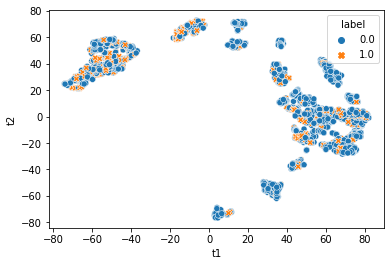

In [156]:
import seaborn as sns
sns.scatterplot(data=dff, x="t1", y="t2", hue="label",style="label")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


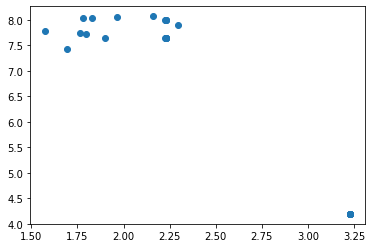

In [148]:
tsne = TSNE(2)
n_items = list(np.unique(data.loc[interactions,'item_id']))
data_tsne = tsne.fit_transform(I.detach().cpu().clone())
plt.scatter(data_tsne[n_items,0],data_tsne[n_items,1])

In [133]:
len(n_items)

27